In [2]:
import sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import re, string, unicodedata
import nltk
#import contractions
import warnings
warnings.filterwarnings('ignore')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [4]:
reddit_data = pd.concat(map(pd.read_csv, ['subreddits_data.csv']))
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
author                   960 non-null object
title                    999 non-null object
score                    999 non-null int64
id                       999 non-null object
url                      999 non-null object
comms_num                999 non-null int64
body                     508 non-null object
timestamp                999 non-null object
author_comments_karma    960 non-null object
author_links_karma       960 non-null object
dtypes: int64(2), object(8)
memory usage: 78.1+ KB


In [5]:
reddit_data.head()

,author,title,score,id,url,comms_num,body,timestamp,author_comments_karma,author_links_karma
0,MockDeath,Help us fight for net neutrality!,83385,7etmk7,https://www.reddit.com/r/askscience/comments/7...,1193,The ability to browse the internet is at risk....,2017-11-22 22:38:53,33852,10762
1,AskScienceModerator,Stephen Hawking megathread,65826,84auzr,https://www.reddit.com/r/askscience/comments/8...,1666,"We were sad to learn that noted physicist, cos...",2018-03-14 09:03:48,1662,290641
2,MockDeath,A message to our users,39287,3by2nk,https://www.reddit.com/r/askscience/comments/3...,1193,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Today in AskScie...,2015-07-03 06:43:47,33852,10762
3,This31415926535,Why is it that during winter it's not uncommon...,37670,7yx524,https://www.reddit.com/r/askscience/comments/7...,976,I live in the USA Midwest,2018-02-20 19:23:37,1364,10337
4,GPL89,If we could travel at 99.9% the speed of light...,34364,ahyapf,https://www.reddit.com/r/askscience/comments/a...,3094,NaN,2019-01-20 17:57:37,4794,13561


In [11]:
#In this dataset there are several columns of type string but they must be numerical.
numeric_columns= ['score','comms_num','author_comments_karma', 'author_links_karma']
for column in numeric_columns:
    reddit_data[column]=pd.to_numeric(reddit_data[column], errors='coerce')

In [12]:
# Column timestamp is of type string, let us convert it to type timestamp
reddit_data['timestamp']=pd.to_datetime(reddit_data['timestamp']) 
# Number of reddits made in each hour of the day.
reddit_data['reddit_created_hour']=reddit_data['timestamp'].apply(lambda time: time.hour)

In [13]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
author                   960 non-null object
title                    999 non-null object
score                    999 non-null int64
id                       999 non-null object
url                      999 non-null object
comms_num                999 non-null int64
body                     508 non-null object
timestamp                999 non-null datetime64[ns]
author_comments_karma    958 non-null float64
author_links_karma       958 non-null float64
reddit_created_hour      999 non-null int64
elapsed_hours            999 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 93.7+ KB


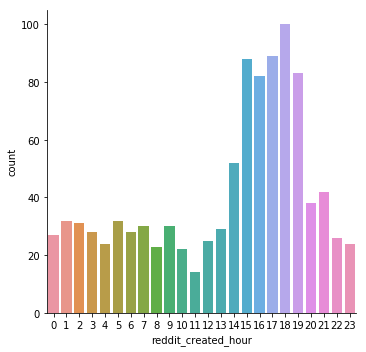

In [14]:
#Let's see the distribution of reddits for each hour.
sns.catplot(x="reddit_created_hour", kind="count", data=reddit_data)
plt.show()


Here we can see that most reddits are published between 3 p.m. and 7 p.m., which is not a surprise.
Now, let us see the distribution of how much time has elapsed since each reddit was created(measured in days).

In [15]:
import datetime
#Time interval(measured in hours) since the reddits was created until now.
reddit_data['elapsed_hours']=reddit_data.timestamp.\
apply(lambda timestamp: (datetime.datetime.now()-timestamp)/np.timedelta64(1,'h'))

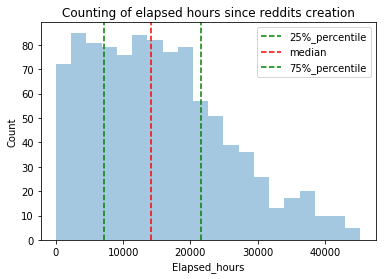

In [16]:
first_percentile =np.percentile(reddit_data['elapsed_hours'],25)
median =np.percentile(reddit_data['elapsed_hours'],50)
third_percentile =np.percentile(reddit_data['elapsed_hours'],75)
sns.distplot(reddit_data['elapsed_hours'], bins=20, kde=False, rug=False)

plt.axvline(first_percentile, color="green",linestyle="--",label="25%_percentile")
plt.axvline(median, color="red",linestyle="--",label="median")
plt.axvline(third_percentile, color="green",linestyle="--",label="75%_percentile")
plt.title('Counting of elapsed hours since reddits creation')
plt.xlabel('Elapsed_hours')
plt.ylabel('Count');
plt.legend()

plt.show()

In [19]:
print("Min and Max hours elapsed since reddit creation, min: {:.0f}, max: {:.0f}."\
      .format(reddit_data['elapsed_hours'].min(),reddit_data['elapsed_hours'].max()))

Min and Max hours elapsed since reddit creation, min: 30, max: 45268.


Quantities such as the score and the number of comments grow over time. Then, the proper way to use these features is to normalize them with respect to elapsed_hours.

In [20]:
# Para hacer el grafico de la frecuencia de los datos numericos primero normalizemos estas features
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler instance
scaler = MinMaxScaler()
#This estimator scales and translates each feature individually 
# From sklearn documentation, the transformation is calculated as follow:
#X_scaled = scale * X + min - X.min(axis=0) * scale
#where scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
# Numeric columns
reddits_standardize =reddit_data[['score','comms_num','author_comments_karma', 'author_links_karma']]
# Taking into account elapsed_hours
reddits_standardize=reddits_standardize.div(reddit_data['elapsed_hours'],axis=0)

# Remove null values
reddits_standardize = reddits_standardize.dropna()
# Fit and transform
X_standardize =scaler.fit_transform(reddits_standardize)
# Dataframe with numeric features
data_standardize = pd.DataFrame(X_standardize,columns=['score','comms_num','author_comments_karma', \
                                                      'author_links_karma'])

In [21]:
data_standardize.head()

,score,comms_num,author_comments_karma,author_links_karma
0,0.025086,0.005659,0.009269,0.001137
1,0.023786,0.009798,0.000566,0.036924
2,0.004690,0.002191,0.004007,0.000490
3,0.012870,0.005333,0.000451,0.001264
4,0.028806,0.043494,0.003660,0.003982


In data_standardize, the values of each feature is normalized to the interval $[0,1]$. But, I am also
interested in exploring the behavior of the logarithm of these columns.
Since logarithm is undefined at zero, let's shift the min of each feature towards $1.0$.

In [22]:
shifted_data_standardize =data_standardize+1.0
log_data_standardize=np.log(shifted_data_standardize)
log_data_standardize.columns=list(map(lambda x: 'log_'+x, data_standardize.columns))
shifted_data_standardize.head()


,score,comms_num,author_comments_karma,author_links_karma
0,1.025086,1.005659,1.009269,1.001137
1,1.023786,1.009798,1.000566,1.036924
2,1.004690,1.002191,1.004007,1.000490
3,1.012870,1.005333,1.000451,1.001264
4,1.028806,1.043494,1.003660,1.003982


In [23]:
# Function that plots histograms of numerical columns.

def plot_histogram(dataframe,column,y_label,title,bins=8):
    '''
    Take a column and plot two histograms, where:
    left: Distribution of column values
    right: Distribution of log of column values
    
    '''
    # Params:
    
    # dataframe is the data frame to plot
    # column is the numeric feature 
    # y_label is the y label 
    # title is the title of the plot
    # bins is the number of bins
     
    
    #Return : 
    
    #Two, left: column values, right: logarithm of column values
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 6),sharey=True)
    fig.suptitle(title)
    # Feature values 
    ax1.hist(dataframe[column],bins=bins,log=True)
    #Log of feature values 
    ax2.hist(np.log(dataframe[column]),bins=bins,log=True)
    # Labels
    ax1.set_xlabel(column, labelpad=15, fontsize=12, color="black");
    ax1.set_ylabel(y_label, labelpad=15, fontsize=12, color="black");
    ax2.set_xlabel("Log of "+ column, labelpad=15, fontsize=12, color="black");
    
    #ax.title.set_text(title)
    #ax.set_axisbelow(True)
    plt.grid(True, alpha=0.5)
    

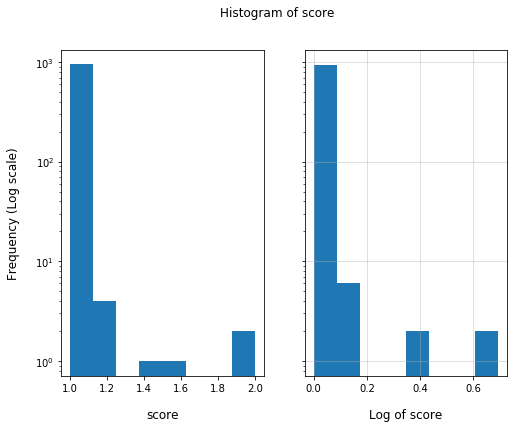

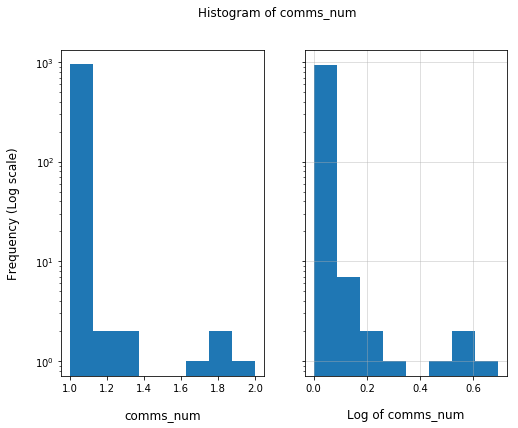

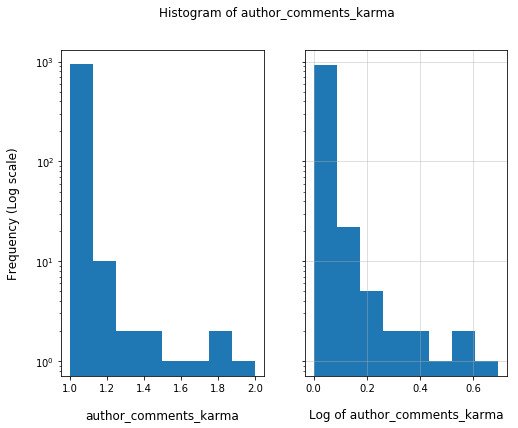

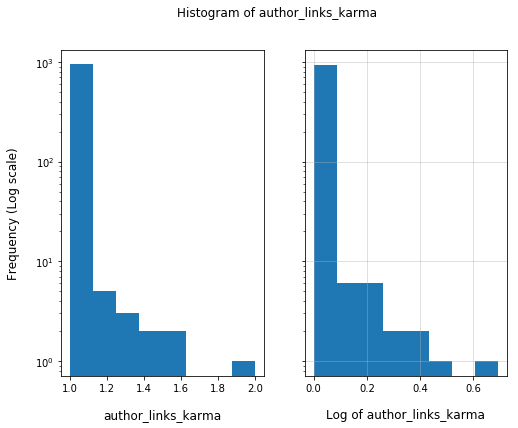

In [24]:
# Histograms of the columns
for column in  shifted_data_standardize.columns:
    plot_histogram(shifted_data_standardize,column,"Frequency (Log scale)", "Histogram of " + column)

The graphics above show very skewed distributions for all features. In fact, this behavior occurs in the plots of the logarithms too. Now, let us analyze the correlation among the  features(in log scale).

In [25]:
log_data_standardize.corr()

,log_score,log_comms_num,log_author_comments_karma,log_author_links_karma
log_score,1.000000,0.970573,0.377244,0.386020
log_comms_num,0.970573,1.000000,0.399495,0.416247
log_author_comments_karma,0.377244,0.399495,1.000000,0.361348
log_author_links_karma,0.386020,0.416247,0.361348,1.000000


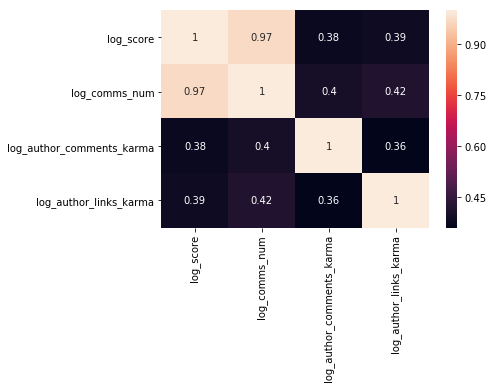

In [26]:
# Generating correlation heatmap 
sns.heatmap(log_data_standardize.corr(), annot = True)  
plt.show() 

Here we have two goups of features. The first group is associated with the reddit author, these features are author_comments_karma	and author_links_karma.The above map suggest a kind of correlation between them. 
The second group is associated with the reddit itself, these are score	and comms_num, in this case there is a strong correlation between them.

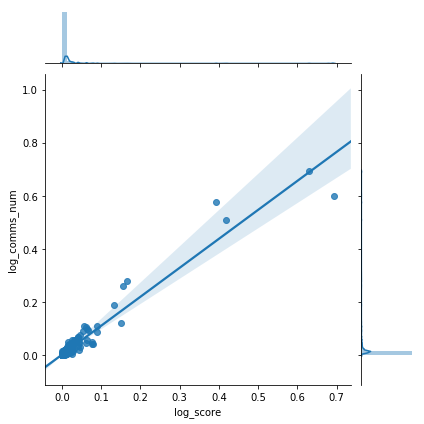

In [27]:
# Regression line for features log_score and log_comms_num
g = sns.jointplot(x=log_data_standardize["log_score"],\
                  y=log_data_standardize["log_comms_num"],\
                  data=log_data_standardize,kind='reg')

As I said before, log_score and  log_comms_num are strongly correlated.

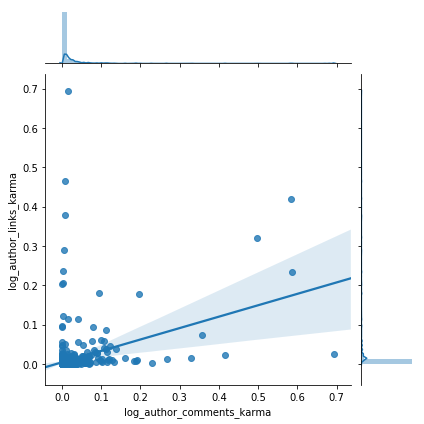

In [28]:
# Regression line for features log_links_karma" and "log_comments_karma
g = sns.jointplot(x=log_data_standardize["log_author_comments_karma"],\
                  y=log_data_standardize["log_author_links_karma"],\
                  data=log_data_standardize,kind='reg')


Here, log_author_comments_karma and log_author_links_karma show a weak correlation between them.

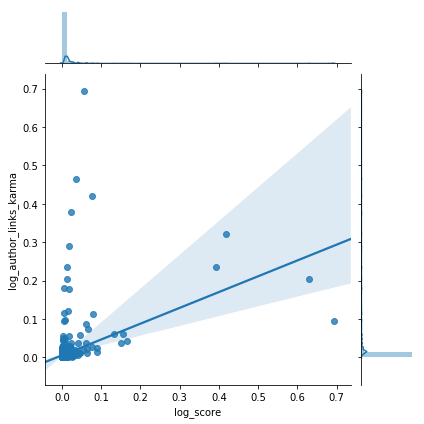

In [29]:
# Regression line for features log_score  and log_author_links_karma
g = sns.jointplot(x=log_data_standardize["log_score"],\
                  y=log_data_standardize["log_author_links_karma"],\
                  data=log_data_standardize,kind='reg')

Here, the correlation is week too.

Let us see if a 3d plot allows us to detect any pattern between these features. 

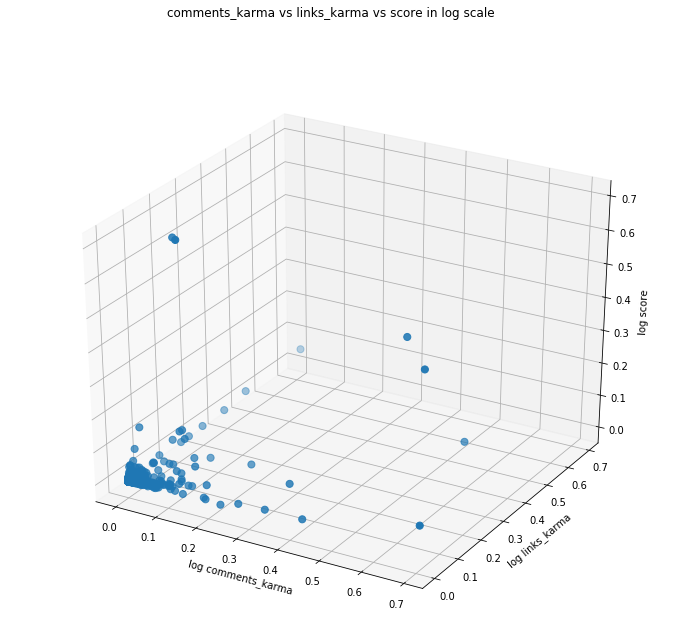

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

x= log_data_standardize["log_author_comments_karma"]
y=log_data_standardize["log_author_links_karma"]
z= log_data_standardize["log_score"]
ax.scatter(x, y, z, s=50)
fig.suptitle('comments_karma vs links_karma vs score in log scale')

ax.set_xlabel('log comments_karma')
ax.set_ylabel('log links_karma')
ax.set_zlabel('log score')

plt.show()
               

Almost all points are grouped at the origin and there are several outliers.
Let us see if reddits are organized by clusters.
First, let us remove the superfluous features,so,  let us use a dimensional reduction technique such as
principal component analysis.

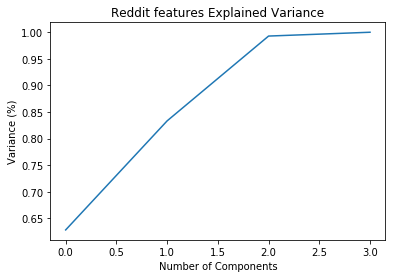

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_standardize=log_data_standardize.values

# Create scaler: scaler
scaler = StandardScaler()

# Create PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

#Fit and transform the pipeline to samples
pipeline.fit_transform(X_standardize)

# Plot percent of variance of each pca_feature
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Reddit features Explained Variance')
plt.show()


From the previous graph, almost $100$% of the variation is explained by $2$ characteristics.

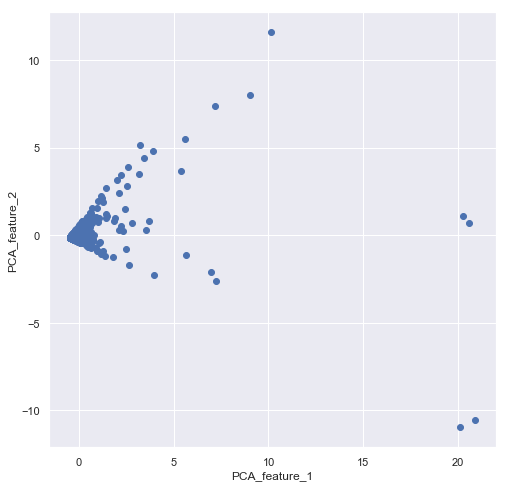

In [32]:
# Create PCA instance: pca
pca = PCA(n_components=2)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)
pipeline.fit(X_standardize)
# The pca features
Xpca = pipeline.transform(X_standardize)

# Plot of datapoints using pca_features
sns.set()
plt.figure(figsize=(8,8))
plt.scatter(Xpca[:,0],Xpca[:,1])
plt.xlabel("PCA_feature_1")
plt.ylabel("PCA_feature_2")
plt.show()

Again, we can see several outliers.
Let us explore some clustering techniques to analyze if our data has clustering structure.
Let us begin with the most popular one: K-Means. Essentially, K-Means sets k centroids in the data and clusters points by assigning them to the nearest centroid.  A way to select the optimal number of clusters is by using the elbow method. At high level, the idea is to find the least number of cluster where you can see  an elbow in the plot of number of clusters vs inertia(check this link https://www.scikit-yb.org/en/latest/api/cluster/elbow.html).

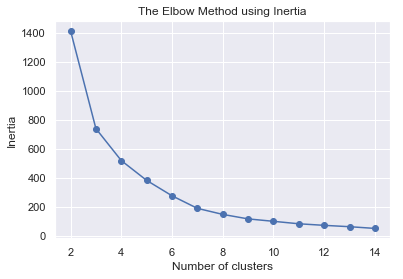

In [33]:
from sklearn.cluster import KMeans
range_n_clusters = range(2,15)
inertias=[]

for k in range_n_clusters: 
    #Building and fitting the model for the chosen number of clusters 
    clusterer_kmeans = KMeans(n_clusters=k)
    cluster_labels = clusterer_kmeans.fit_predict(Xpca)
    # Adding inertias to a list 
    inertias.append(clusterer_kmeans.inertia_) 
    
# Number of clusters vs Inertias   
plt.plot(range_n_clusters, inertias, 'bo-') 
plt.xlabel('Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

The elbow method suggests us that there are 2-6 clusters in the dataset.
Let us explore the silhouette method for different clustering algorithms.
The silhouette value determines how similar a given point  is to its own cluster compared to other clusters. The Silhouette values  are in the interval $[-1,1]$, where $1$ indicates that the point is well matched to its own cluster and poorly matched to neighboring clusters. If most pints  have a high value, then the clustering configuration is appropriate. 

In [34]:
from sklearn.cluster import AgglomerativeClustering as AggClus
from sklearn.cluster import SpectralClustering as SpectClus
from sklearn.metrics import silhouette_samples, silhouette_score
#import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
import re 



def silhouette_plots(range_n_clusters,X,method=KMeans):
    # Params:
    # range_n_clusters is a list containing the different cluster numbers that we are going to analyze.
    # X is the  data
    # method is the clustering method
    
    # Return:
    # Two plots, for each number of clusters, left plot: silhouette_score 
    #and right plot: is the scatter plot of our features 
    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(14, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.4, 1]
        ax1.set_xlim([-0.6, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value 
        clusterer = method(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        if method == KMeans:
            centers = clusterer.cluster_centers_
            #Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',\
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,\
                            s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        # Get the name of the clustering method
        method_name=str(method().__class__)
        # Extract only the name 
        str_method= re.findall(r".[\w]+'", method_name)[0][1:-1]
        
        plt.suptitle(("Silhouette analysis for " + str_method + " on sample data with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        
        

    plt.show()

In [35]:
range_n_clusters = [2,3,4,6]

For n_clusters = 2 The average silhouette_score is : 0.9651754102469079
For n_clusters = 3 The average silhouette_score is : 0.904734615066905
For n_clusters = 4 The average silhouette_score is : 0.869542617550274
For n_clusters = 6 The average silhouette_score is : 0.8633438150193508


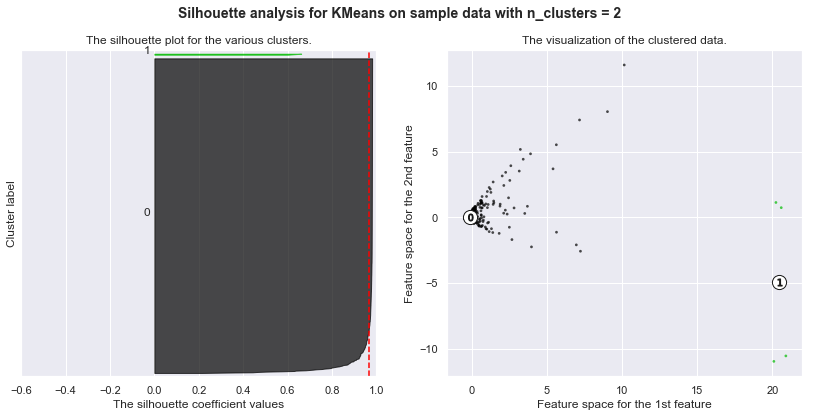

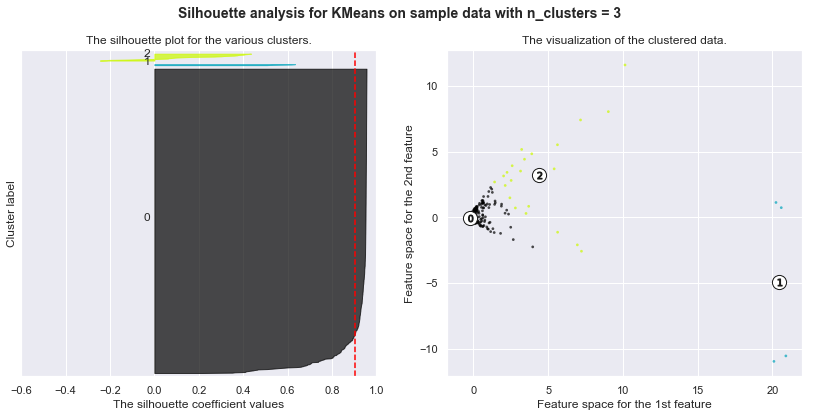

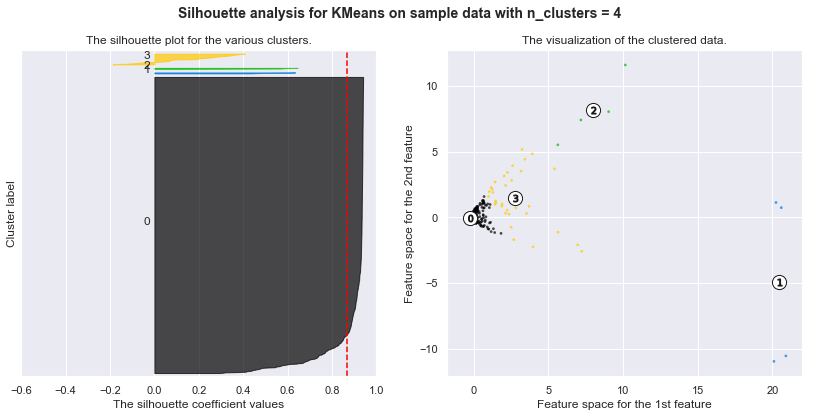

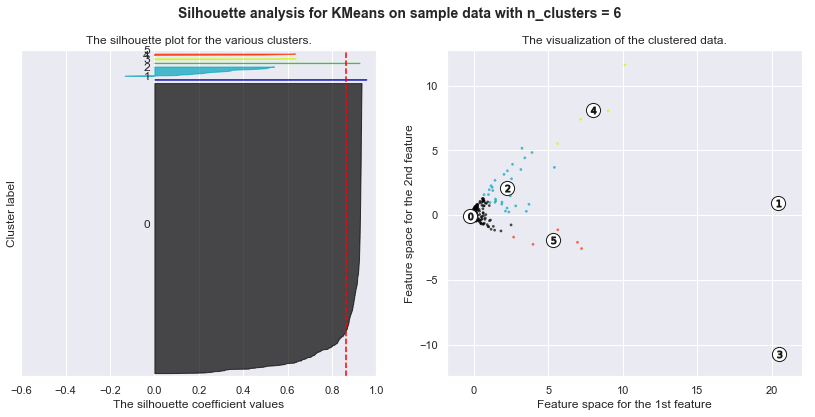

In [36]:
silhouette_plots(range_n_clusters,Xpca,KMeans);

For n_clusters = 2 The average silhouette_score is : 0.7884413373488401
For n_clusters = 3 The average silhouette_score is : 0.6239228210103447
For n_clusters = 4 The average silhouette_score is : 0.5200870032479755
For n_clusters = 6 The average silhouette_score is : 0.5120776086605029


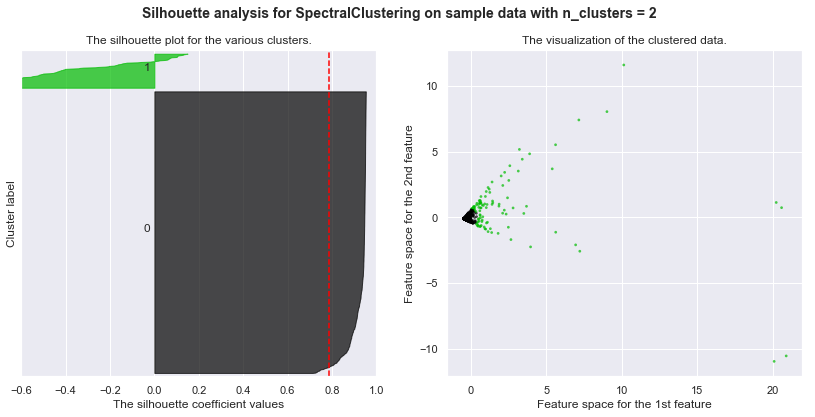

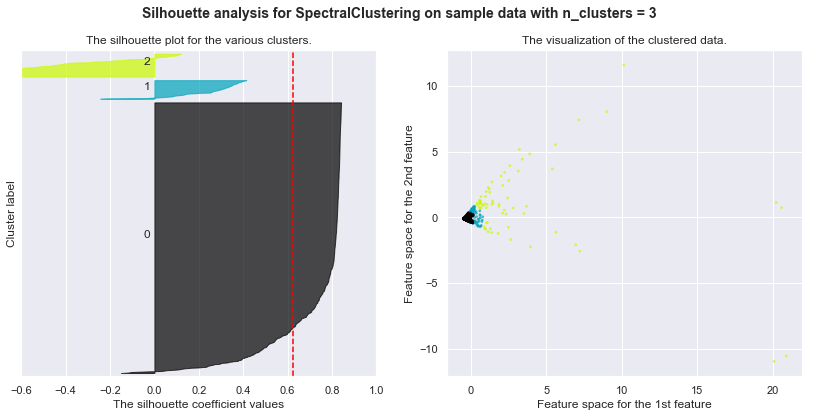

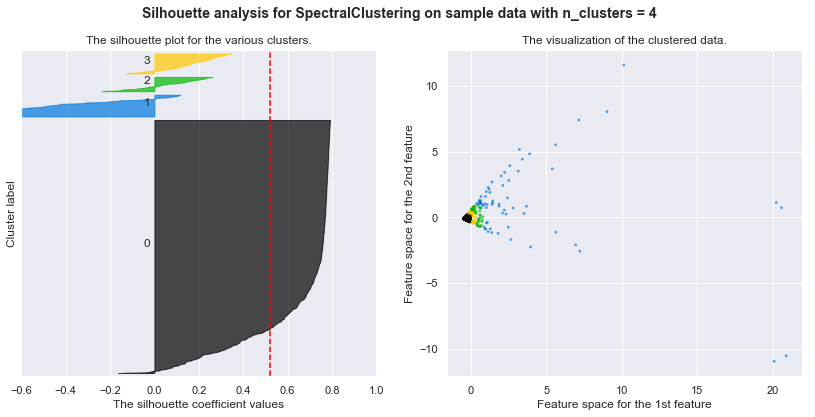

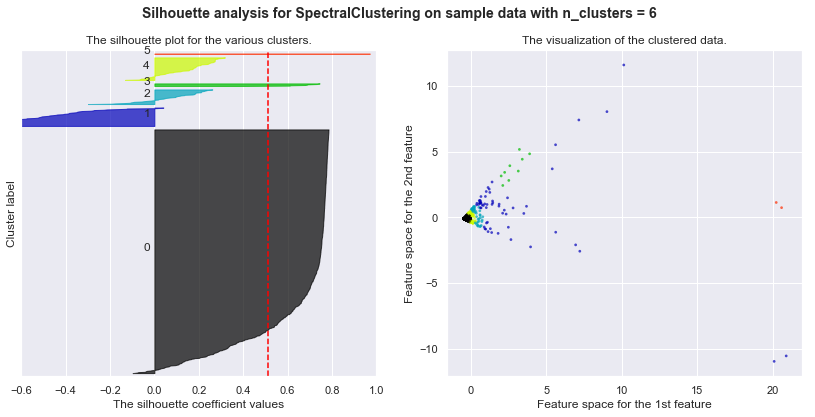

In [37]:
silhouette_plots(range_n_clusters,Xpca,SpectClus) 

For n_clusters = 2 The average silhouette_score is : 0.9651754102469079
For n_clusters = 3 The average silhouette_score is : 0.8464082308273506
For n_clusters = 4 The average silhouette_score is : 0.840031023165797
For n_clusters = 6 The average silhouette_score is : 0.8270434767624244


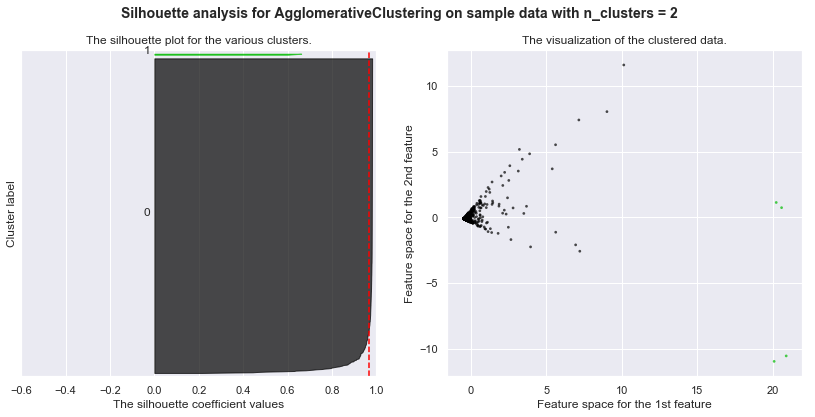

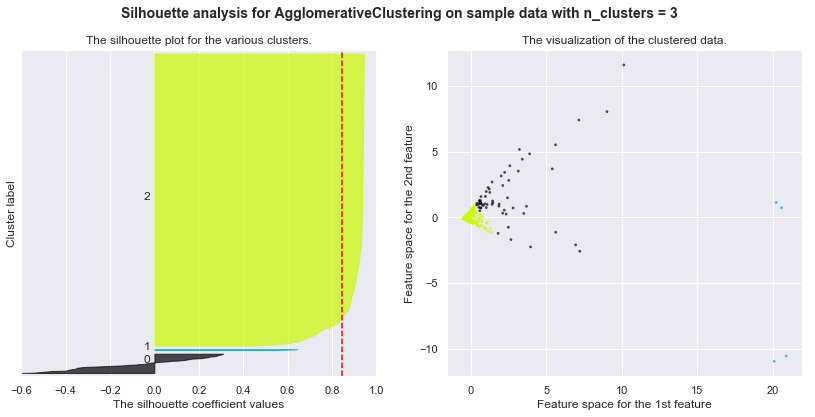

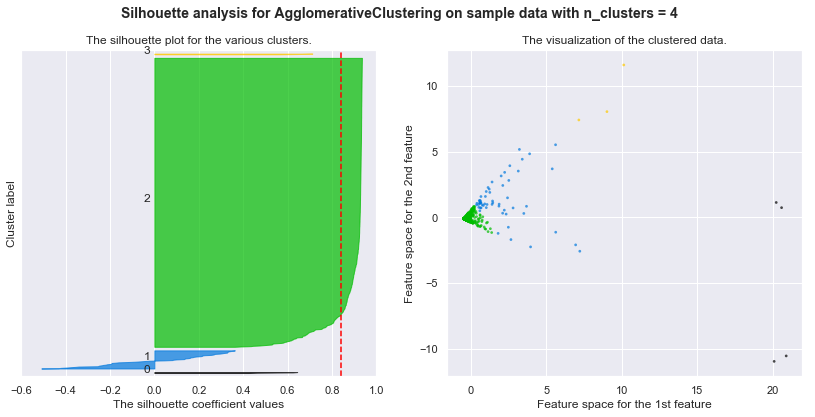

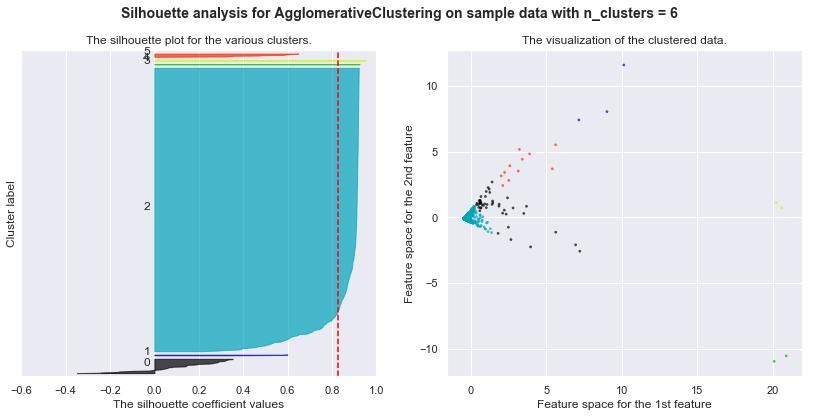

In [38]:
silhouette_plots(range_n_clusters,Xpca,AggClus) 

By using various clustering methods, the silhouette score suggests that the optimal number of clusters is 2.
Let us study  density-based clustering, this kind of algorithms  are good identifying data points that deviate from the normal distribution, in other words, outliers. A popular density based method is DBSCAN. This method  does not require the number of clusters as a parameter. Here, the main parameters are the radius of the neighborhoods and the minimum number points you want in a neighborhood to define a cluster.

In [39]:
from sklearn.cluster import DBSCAN
# Object dbscan
dbsc = DBSCAN(eps = .8, min_samples = 10)
# fit and transform
labels_dbsc = dbsc.fit_predict(Xpca)


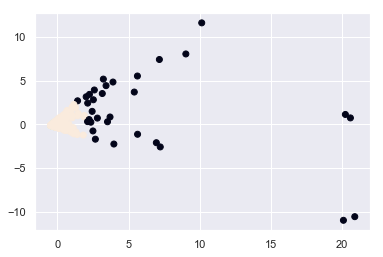

In [40]:
plt.scatter(Xpca[:,0],Xpca[:,1],c=labels_dbsc);

Let us see how these two clusters look in our original data.

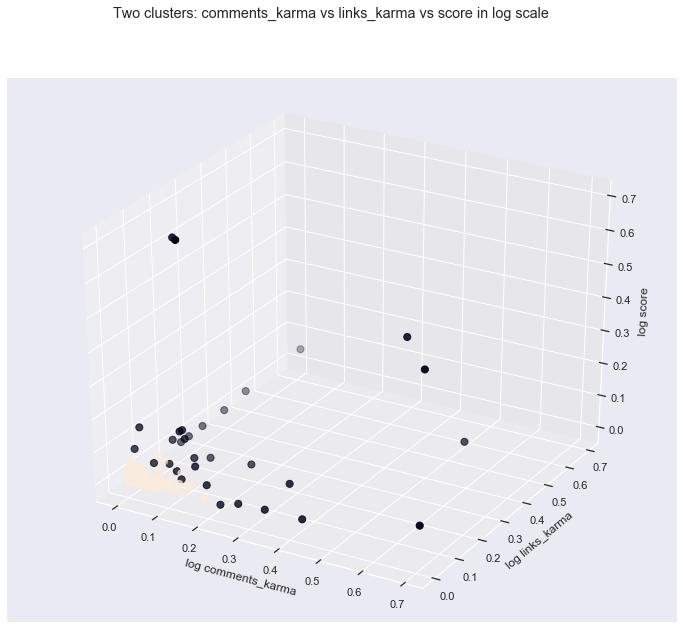

In [41]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

x= log_data_standardize["log_author_comments_karma"]
y=log_data_standardize["log_author_links_karma"]
z= log_data_standardize["log_score"]
ax.scatter(x, y, z, s=50,c=labels_dbsc)
fig.suptitle('Two clusters: comments_karma vs links_karma vs score in log scale')

ax.set_xlabel('log comments_karma')
ax.set_ylabel('log links_karma')
ax.set_zlabel('log score')

plt.show()




Let us see what are the most used words in  reddits that are outliers.

In [42]:
reddits_not_null=reddit_data[~reddit_data.author_comments_karma.isnull()]
# New column with cluster labels
reddits_not_null['is_outliers'] =labels_dbsc

In [43]:
reddits_not_null['is_outliers'].value_counts()

 0    926
-1     32
Name: is_outliers, dtype: int64

There are 32 outliers in our dataset.

In [44]:
# Outliers reddits 
reddits_not_null[reddits_not_null['is_outliers']==-1]

,author,title,score,id,url,comms_num,body,timestamp,author_comments_karma,author_links_karma,reddit_created_hour,elapsed_hours,is_outliers
13,simrc86,Why do nearsighted people need a prescription ...,25998,d26nwr,https://www.reddit.com/r/askscience/comments/d...,1282,NaN,2019-09-10 16:12:07,2382.0,7453.0,16,126.725281,-1
46,ArchmageIlmryn,"When someone is dying of hunger or thirst, is ...",17287,ch9pwm,https://www.reddit.com/r/askscience/comments/c...,946,"And if this point exists, would someone who's ...",2019-07-24 19:35:23,36448.0,8579.0,19,1275.337503,-1
47,Notmiefault,The Gunpowder Plot involved 36 barrels of gunp...,17133,9uj3zn,https://www.reddit.com/r/askscience/comments/9...,652,I’m curious if such a blast would have success...,2018-11-06 02:58:22,530356.0,57311.0,2,7531.954447,-1
86,GrumpyWendigo,If a 20 year old gets an organ transplant from...,14100,akzk33,https://www.reddit.com/r/askscience/comments/a...,599,NaN,2019-01-29 15:32:16,496002.0,49717.0,15,5503.389448,-1
88,Falling2311,Is there really no better way to diagnose ment...,13992,cr6fq9,https://www.reddit.com/r/askscience/comments/c...,804,I'm notorious for choosing the wrong words to ...,2019-08-16 17:34:11,29157.0,6529.0,17,725.357503,-1
110,Morgz789,"How can cheese be ""aged"" so long, but when it'...",13291,cwa1u2,https://www.reddit.com/r/askscience/comments/c...,1157,NaN,2019-08-28 00:27:40,11939.0,16603.0,0,454.466115,-1
167,4x49ers,[Neuroscience] Why can't we use adrenaline or ...,11209,cs0win,https://www.reddit.com/r/askscience/comments/c...,432,NaN,2019-08-18 17:01:57,156158.0,10615.0,17,677.894726,-1
177,You_Suck_Ya_Jackass,How do super storms like Hurricane Dorian affe...,11011,cyi0rj,https://www.reddit.com/r/askscience/comments/c...,526,"Edit: Thank you, anonymous do-gooder for the g...",2019-09-02 04:45:47,753.0,7287.0,4,330.164171,-1
182,Trifle-Doc,Megalodon is often depicted as an enlarged Gre...,10968,coxtdp,https://www.reddit.com/r/askscience/comments/c...,489,NaN,2019-08-11 19:07:31,16676.0,18742.0,19,843.801948,-1
266,actually_crazy_irl,Does a diamond melt in lava?,9343,9h496k,https://www.reddit.com/r/askscience/comments/9...,753,Trying to settle a dispute between two 6-year-...,2018-09-19 15:15:43,196634.0,1020949.0,15,8671.665282,-1


Before exploring the most common words used in the reddits for each cluster, let us  normalize the text of the titles.

In [45]:
def normalization(words):
    #Params: words is the words in title
    
    #Return: normalized list of words
    
    list_words = []
    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    for word in words:
        #Remove non-ASCII characters from the word
        word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        # Convert all characters to lowercase
        word = word.lower()
        #Removing punctuation
        word = re.sub(r'[^A-Za-z\s]', '', word)
        #Removing stop words
        if word != '' and  word not in stopwords.words('english'):
            #word = stemmer.stem(word)
            # Eliminating short words and maintaining negations
            if (word !='no' or word !='nt')  and len(word)>2:
                word = lemmatizer.lemmatize(word, pos='v')
            
            list_words.append(word)
    return list_words


In [46]:
# Words tokenizer
tokenized_title=reddits_not_null.title.apply(lambda entry: nltk.word_tokenize(entry))

In [47]:
# Normalization of titles
clean_titles=tokenized_title.apply(lambda entry: normalization(entry))

In [48]:
#Transforming each entry of clean_titles from type list to string.
reddits_not_null['clean_title']=clean_titles.apply(lambda x: " ".join(x))
reddits_not_null.head()

,author,title,score,id,url,comms_num,body,timestamp,author_comments_karma,author_links_karma,reddit_created_hour,elapsed_hours,is_outliers,clean_title
0,MockDeath,Help us fight for net neutrality!,83385,7etmk7,https://www.reddit.com/r/askscience/comments/7...,1193,The ability to browse the internet is at risk....,2017-11-22 22:38:53,33852.0,10762.0,22,15888.279169,0,help us fight net neutrality
1,AskScienceModerator,Stephen Hawking megathread,65826,84auzr,https://www.reddit.com/r/askscience/comments/8...,1666,"We were sad to learn that noted physicist, cos...",2018-03-14 09:03:48,1662.0,290641.0,9,13213.863892,0,stephen hawk megathread
2,MockDeath,A message to our users,39287,3by2nk,https://www.reddit.com/r/askscience/comments/3...,1193,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Today in AskScie...,2015-07-03 06:43:47,33852.0,10762.0,6,36856.197503,0,message users
3,This31415926535,Why is it that during winter it's not uncommon...,37670,7yx524,https://www.reddit.com/r/askscience/comments/7...,976,I live in the USA Midwest,2018-02-20 19:23:37,1364.0,10337.0,19,13731.533614,0,winter uncommon days abnormally high temperatu...
4,GPL89,If we could travel at 99.9% the speed of light...,34364,ahyapf,https://www.reddit.com/r/askscience/comments/a...,3094,NaN,2019-01-20 17:57:37,4794.0,13561.0,17,5716.966947,0,could travel speed light would take years get ...


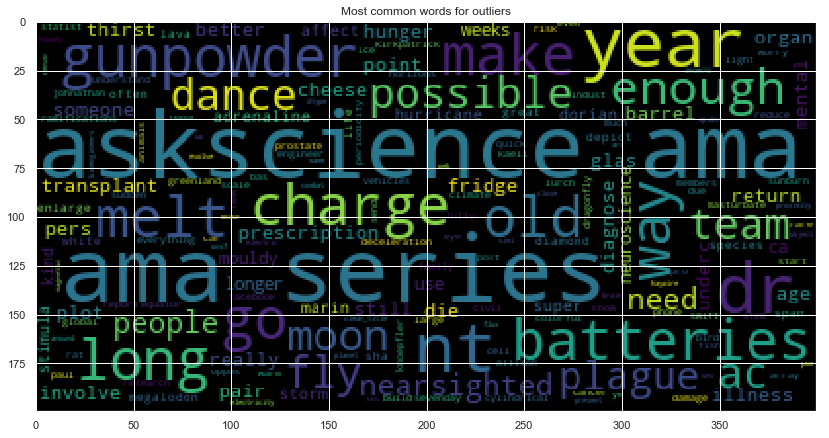

In [49]:
# Most used words for outliers 
from wordcloud import WordCloud, STOPWORDS
word_cloud = WordCloud(stopwords=STOPWORDS)
plt.figure(figsize=(14, 14))
word_cloud.generate(str(reddits_not_null[reddits_not_null['is_outliers']==-1].clean_title))
plt.imshow(word_cloud)
plt.title('Most common words for outliers')
plt.show()

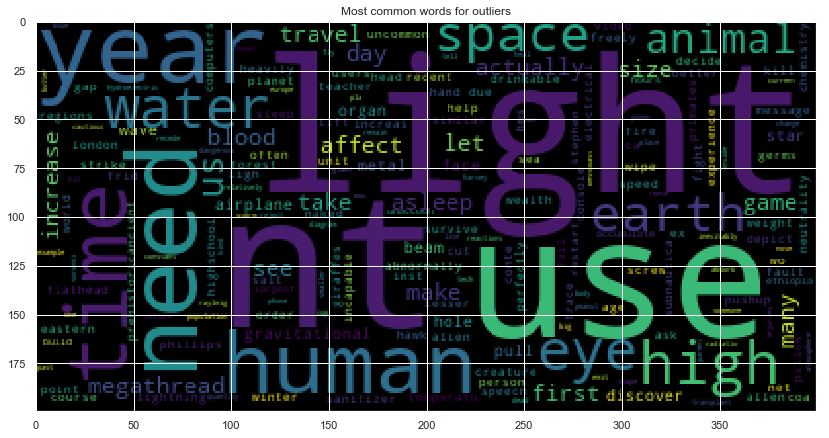

In [51]:
# Most used words for non outliers 
word_cloud = WordCloud(stopwords=STOPWORDS)
plt.figure(figsize=(14, 14))
word_cloud.generate(str(reddits_not_null[reddits_not_null['is_outliers']==0].clean_title))
plt.imshow(word_cloud)
plt.title('Most common words for outliers')
plt.show()